### Sales forecasting system
We want to set up our company's warehouse in another location and we need to estimate the rate of sales, which has been increasing since the company's creation, for the next few months in order to provide the space we will need.

In [23]:
# Step 0 Import Libreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.arima.model import ARIMA
from pickle import dump

In [3]:
# 1. Load data
df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [4]:
df_raw.sample(10)

,date,sales
40,2022-10-13 17:10:08.079328,150.963930
125,2023-01-06 17:10:08.079328,374.893562
232,2023-04-23 17:10:08.079328,652.207032
57,2022-10-30 17:10:08.079328,199.263580
238,2023-04-29 17:10:08.079328,670.730831
22,2022-09-25 17:10:08.079328,109.853583
327,2023-07-27 17:10:08.079328,907.866061
161,2023-02-11 17:10:08.079328,474.829692
300,2023-06-30 17:10:08.079328,826.902337
332,2023-08-01 17:10:08.079328,916.429348


In [5]:
# 2. Convert data
df_interim = df_raw.copy()
df_interim['date'] = df_interim['date'].astype('datetime64[ns]')
ts = df_interim['sales']
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    366 non-null    datetime64[ns]
 1   sales   366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [6]:
df_interim.tail(10)

,date,sales
356,2023-08-25 17:10:08.079328,971.046134
357,2023-08-26 17:10:08.079328,977.744160
358,2023-08-27 17:10:08.079328,980.341854
359,2023-08-28 17:10:08.079328,986.244637
360,2023-08-29 17:10:08.079328,989.081673
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214
365,2023-09-03 17:10:08.079328,1000.482785


In [7]:
ts

0        55.292157
1        53.803211
2        58.141693
3        64.530899
4        66.013633
          ...     
361     989.600354
362     994.987326
363     995.814415
364     997.350214
365    1000.482785
Name: sales, Length: 366, dtype: float64

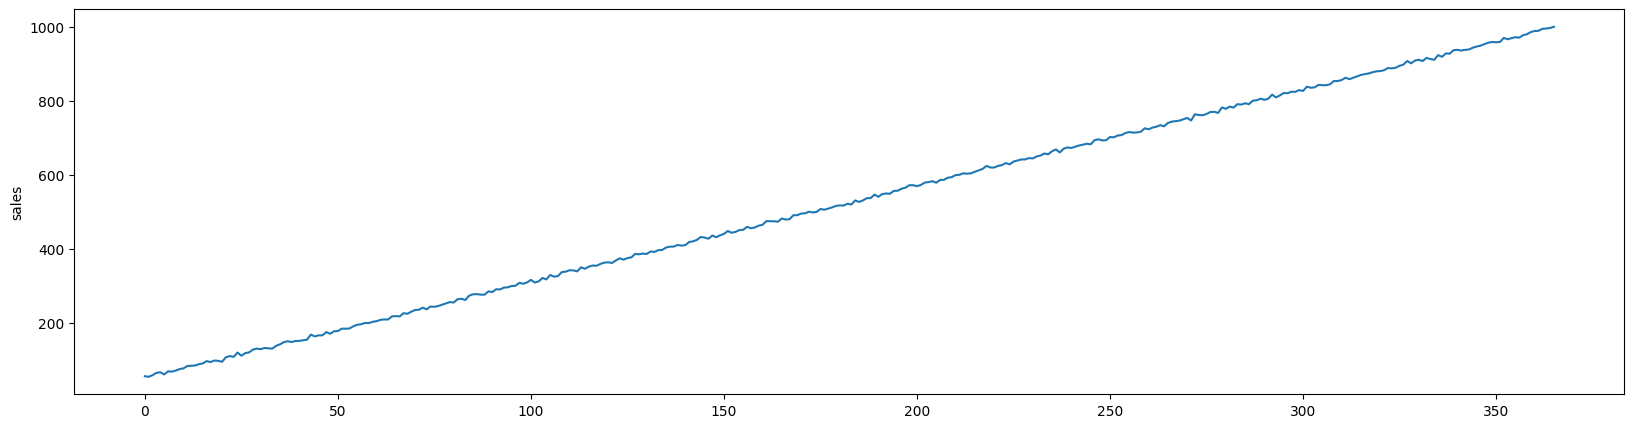

In [8]:
# 3. Visualize the time series 
fig, axis = plt.subplots(figsize = (20, 5))
sns.lineplot(data=ts)
plt.show()

Per this graphic we can conclude **trend** for sales is growing, that the **tensor** is a month, sice we have to give information for the upcoming months. It is unclear if there is **seasonality** present. 

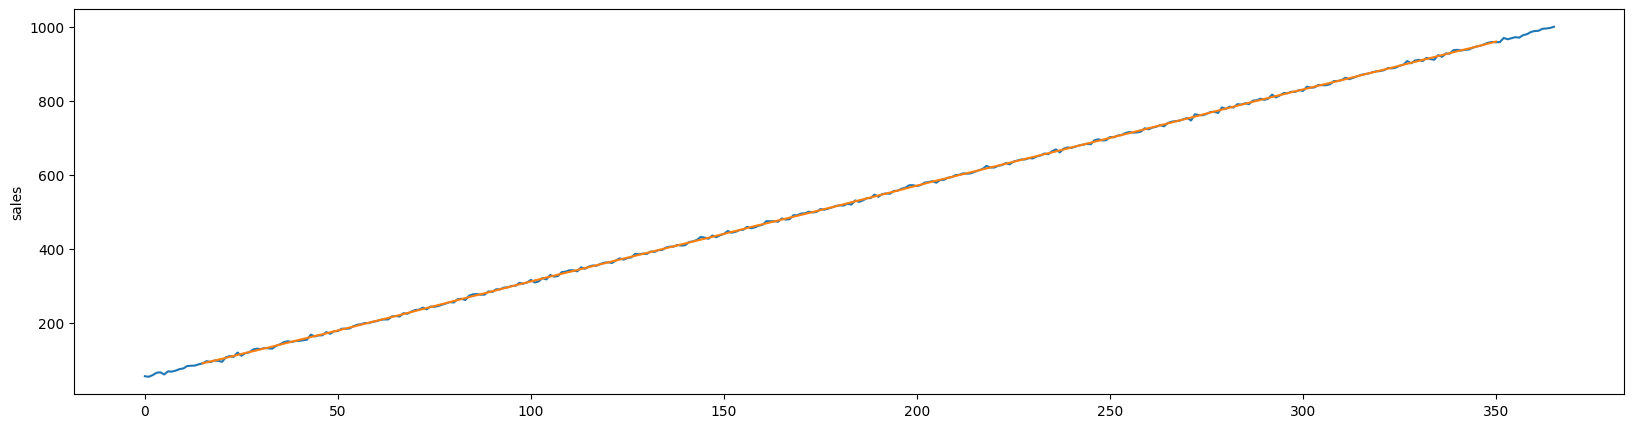

In [9]:
decomposition = seasonal_decompose(ts, period=30)
trend = decomposition.trend
fig, axis = plt.subplots(figsize = (20, 5))
sns.lineplot(ts)
sns.lineplot(trend)
plt.show()

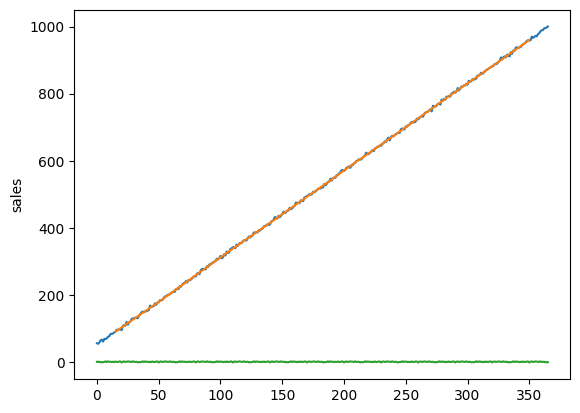

In [10]:
decomposition = seasonal_decompose(ts, period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
sns.lineplot(ts)
sns.lineplot(trend)
sns.lineplot(seasonal)
plt.show()

In [11]:
# 4. Construct and analyze the time series
def test_stationarity(time_series):
    print("Results")
    df_test = adfuller(time_series, autolag='AIC')
    df_out = pd.Series(df_test[0:4], index=['test statistic', 'pvalue', 'lags', 'no observations'])
    for key, value in df_test[4].items():
        df_out['critical values (%s)'%key] = value
    
    return df_out

test_stationarity(ts)

Results


test statistic             0.545414
pvalue                     0.986190
lags                      13.000000
no observations          352.000000
critical values (1%)      -3.449065
critical values (5%)      -2.869786
critical values (10%)     -2.571163
dtype: float64

Here we can see that the p-value is greater than 0.05, which means that our null hypothesis will be rejected, and we will take this series as non-stationary.

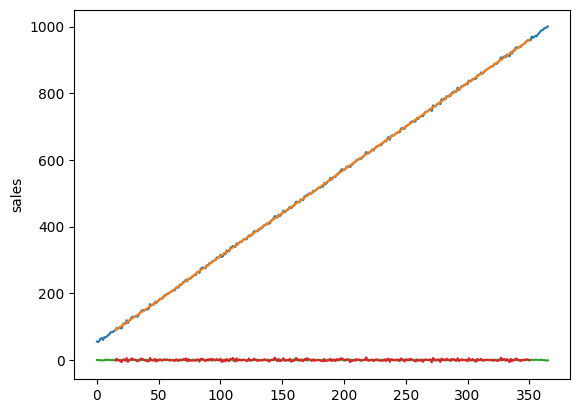

In [12]:
decomposition = seasonal_decompose(ts, period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
sns.lineplot(ts)
sns.lineplot(trend)
sns.lineplot(seasonal)
sns.lineplot(residual)
plt.show()

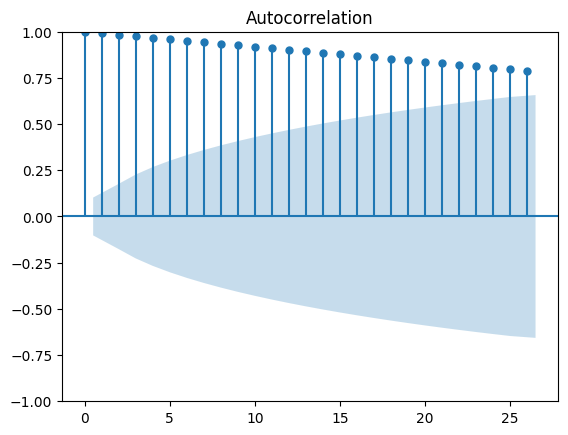

In [13]:
plot_acf(ts)
plt.show()

As we progress through the time series, the autocorrelation is regularly lost, which hampers the predictive ability of the model.

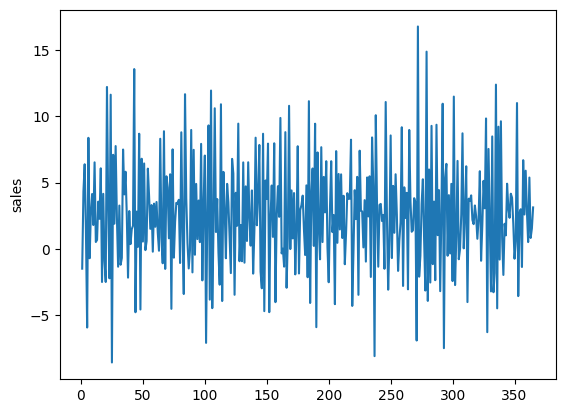

In [14]:
ts_stationary = ts.diff().dropna() # diff t+1 - t
sns.lineplot(ts_stationary)
plt.show()

In [15]:
test_stationarity(ts_stationary)

Results


test statistic          -9.430263e+00
pvalue                   5.212954e-16
lags                     1.200000e+01
no observations          3.520000e+02
critical values (1%)    -3.449065e+00
critical values (5%)    -2.869786e+00
critical values (10%)   -2.571163e+00
dtype: float64

In [16]:
# 5. Train the model
model = ARIMA(ts_stationary, order=(0,0,1))
model_fit = model.fit()

/workspaces/tareas/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/workspaces/tareas/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/workspaces/tareas/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [17]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  365
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -916.793
Date:                Sun, 08 Dec 2024   AIC                           1839.587
Time:                        03:12:29   BIC                           1851.287
Sample:                             0   HQIC                          1844.237
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5988      0.006    420.816      0.000       2.587       2.611
ma.L1         -0.9639      0.016    -60.102      0.000      -0.995      -0.932
sigma2         8.8320      0.695     12.708      0.000       7.470      10.194
===================================================================================
Ljung-Box (L1) (Q):                   1.39   Jarque-Bera (JB):                 1.09
Prob(Q):                              0.24   Prob(JB):                         0.58
Heteroskedasticity (H):               0.90   Skew:                             0.09
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# 6. Model prediction
forecast = model_fit.forecast(30)
forecast

/workspaces/tareas/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/workspaces/tareas/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


365    1.645164
366    2.598813
367    2.598813
368    2.598813
369    2.598813
370    2.598813
371    2.598813
372    2.598813
373    2.598813
374    2.598813
375    2.598813
376    2.598813
377    2.598813
378    2.598813
379    2.598813
380    2.598813
381    2.598813
382    2.598813
383    2.598813
384    2.598813
385    2.598813
386    2.598813
387    2.598813
388    2.598813
389    2.598813
390    2.598813
391    2.598813
392    2.598813
393    2.598813
394    2.598813
Name: predicted_mean, dtype: float64

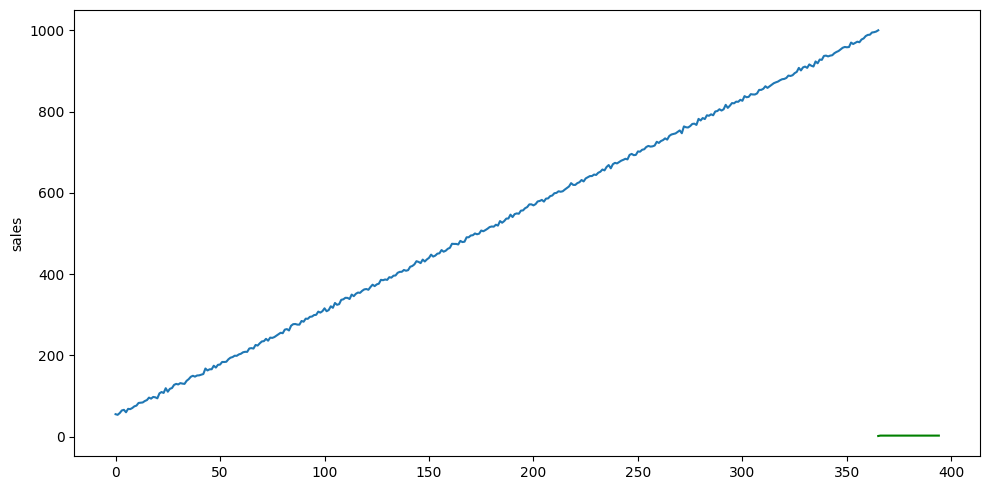

In [21]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

In [24]:
# Save the model
dump(model, open("alternative_time_series.sav", "wb"))